--- 1. Carregando a Base de Dados: BaseFinal(v1).csv ---
Classes Treino (Original): Counter({1: 17233, 0: 1568})
--------------------------------------------------
--- 4. Aplicando Pré-Processamento (Padronização) ---
Padronização/Escalonamento concluído.
--------------------------------------------------
--- 5. Balanceamento Híbrido (RUS 0.1 -> SMOTE) ---
Classes Treino (APÓS Híbrido): Counter({0: 15680, 1: 15680})
--------------------------------------------------
--- 6.5. Aplicando MinMax (Necessário para BernoulliNB) ---
Re-escalonamento MinMax concluído.
--------------------------------------------------
--- 7. Ajuste Automático de Hiperparâmetros (BernoulliNB + BayesSearchCV) ---

✅ Melhores Parâmetros (F1-Score) Encontrados: OrderedDict({'alpha': 0.8642410048155081})
✅ Melhor F1-Score (Validação Cruzada): 0.7703
--------------------------------------------------
Relatório de Classificação no Conjunto de Teste (Desbalanceado):
              precision    recall  f1-score   support

<Figure size 800x600 with 0 Axes>

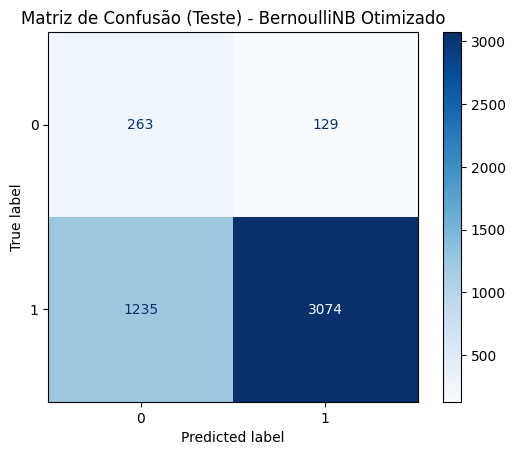


--- 10. Plotando Curva ROC ---


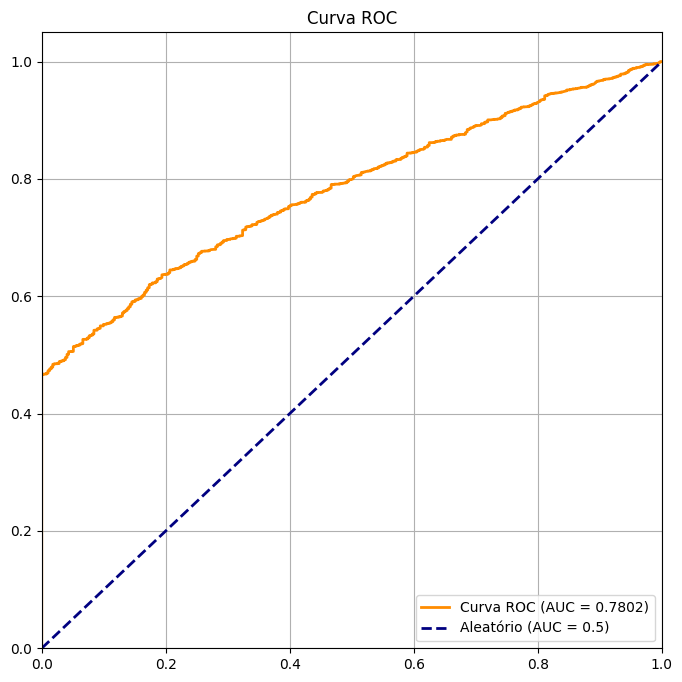

Valor final do AUC: 0.7802


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Adicionado para gráficos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Adicionado MinMaxScaler
from sklearn.metrics import classification_report, make_scorer, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve # Novas métricas e gráficos
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.naive_bayes import BernoulliNB # NOVO: Melhor para features binárias/OHE

# 🚨 Importações para a Otimização Bayesiana (Certifique-se de que 'scikit-optimize' está instalado)
from skopt import BayesSearchCV
from skopt.space import Real 

# --- VARIÁVEIS DE CONFIGURAÇÃO DO PROJETO ARTRITE ---
NOME_ARQUIVO_ENTRADA = "BaseFinal(v1).csv" # Base imputada pelo KNNImputer
NOME_COLUNA_TARGET = 'TEM_ARTRITE' 
# ... (Nomes dos arquivos de saída omitidos para brevidade)
# ---------------------------------------------------

try:
    # 1. Carregamento, 2. Definição de Features/Target e 3. Divisão em Treino/Teste
    print(f"--- 1. Carregando a Base de Dados: {NOME_ARQUIVO_ENTRADA} ---")
    base = pd.read_csv(NOME_ARQUIVO_ENTRADA) 
    X_prev = base.drop(columns=[NOME_COLUNA_TARGET])
    y_classe = base[NOME_COLUNA_TARGET]
    
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X_prev, y_classe, test_size=0.20, random_state=42, stratify=y_classe 
    )
    print(f"Classes Treino (Original): {Counter(y_treino)}")
    print("-" * 50)
    
    # 4. Pré-Processamento (Padronização)
    print("--- 4. Aplicando Pré-Processamento (Padronização) ---")
    scaler = StandardScaler()
    X_treino_scaled = scaler.fit_transform(X_treino)
    X_teste_scaled = scaler.transform(X_teste) 
    X_treino_df = pd.DataFrame(X_treino_scaled, columns=X_treino.columns)
    X_teste_df = pd.DataFrame(X_teste_scaled, columns=X_teste.columns)
    y_treino = y_treino.reset_index(drop=True)
    y_teste = y_teste.reset_index(drop=True)
    print("Padronização/Escalonamento concluído.")
    print("-" * 50)

    # 5. Balanceamento Híbrido (RUS -> SMOTE) - APENAS NO TREINO
    print("--- 5. Balanceamento Híbrido (RUS 0.1 -> SMOTE) ---")
    rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
    X_rus, y_rus = rus.fit_resample(X_treino_df, y_treino)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_rus, y_rus) 
    print(f"Classes Treino (APÓS Híbrido): {Counter(y_resampled)}")
    print("-" * 50)
    
    # 6.5. Re-escalonamento para Naive Bayes (MinMaxScaler)
    print("--- 6.5. Aplicando MinMax (Necessário para BernoulliNB) ---")
    minmax_scaler = MinMaxScaler()
    # Usamos o fit_transform no treino balanceado e apenas transform no teste
    X_resampled_nb = minmax_scaler.fit_transform(X_resampled)
    X_teste_nb = minmax_scaler.transform(X_teste_df) 
    
    X_resampled_nb_df = pd.DataFrame(X_resampled_nb, columns=X_resampled.columns)
    X_teste_nb_df = pd.DataFrame(X_teste_nb, columns=X_teste_df.columns)
    print("Re-escalonamento MinMax concluído.")
    print("-" * 50)

    # 7. Ajuste de Hiperparâmetros com BayesSearchCV (BernoulliNB)
    print("--- 7. Ajuste Automático de Hiperparâmetros (BernoulliNB + BayesSearchCV) ---")

    search_spaces = {
        # Ampliamos o espaço de busca
        'alpha': Real(1e-5, 1000.0, prior='log-uniform') 
    }
    # Métrica de Otimização: F1-Score (Equilíbrio entre Precisão e Recall)
    scorer = make_scorer(f1_score, pos_label=1)

    bayes_search = BayesSearchCV(
        estimator=BernoulliNB(), # NOVO ESTIMADOR: BernoulliNB
        search_spaces=search_spaces,
        n_iter=100, # Aumentamos as iterações
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    bayes_search.fit(X_resampled_nb_df, y_resampled) 
    
    # 7.5. Extrair o Melhor Modelo e Parâmetros
    modelo_nb_best = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    best_score = bayes_search.best_score_

    print(f"\n✅ Melhores Parâmetros (F1-Score) Encontrados: {best_params}")
    print(f"✅ Melhor F1-Score (Validação Cruzada): {best_score:.4f}")
    print("-" * 50)


    # 8. Avaliação do Melhor Modelo no Conjunto de Teste
    
    # Avalia usando o conjunto de TESTE re-escalonado
    y_pred = modelo_nb_best.predict(X_teste_nb_df)
    y_pred_proba = modelo_nb_best.predict_proba(X_teste_nb_df)[:, 1] 

    print("Relatório de Classificação no Conjunto de Teste (Desbalanceado):")
    print(classification_report(y_teste, y_pred))
    print("-" * 50)
    
    
    # 9. Plotagem da Matriz de Confusão
    print("--- 9. Plotando Matriz de Confusão ---")
    
    cm = confusion_matrix(y_teste, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_nb_best.classes_)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Matriz de Confusão (Teste) - BernoulliNB Otimizado")
    plt.show()

    
    # 10. Plotagem da Curva ROC
    print("\n--- 10. Plotando Curva ROC ---")
    
    fpr, tpr, thresholds = roc_curve(y_teste, y_pred_proba)
    roc_auc = roc_auc_score(y_teste, y_pred_proba)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    print(f"Valor final do AUC: {roc_auc:.4f}")

except FileNotFoundError:
    print(f"❌ ERRO: O arquivo '{NOME_ARQUIVO_ENTRADA}' não foi encontrado.")
except ImportError as e:
    # Captura erro se o skopt não estiver instalado
    if 'skopt' in str(e):
         print("❌ ERRO: A biblioteca 'scikit-optimize (skopt)' não está instalada. Execute: pip install scikit-optimize")
    else:
         print(f"❌ ERRO: Verifique se todas as bibliotecas estão instaladas. Erro: {e}")
except Exception as e:
    print(f"❌ Ocorreu um erro durante o processamento: {e}")


--- 11. Random Forest (RF) Otimizado com class_weight='balanced' ---


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

<Figure size 800x600 with 0 Axes>

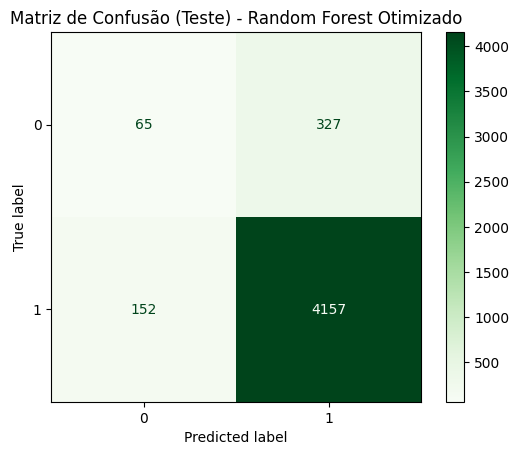


--- 14. Plotando Curva ROC (Random Forest) ---


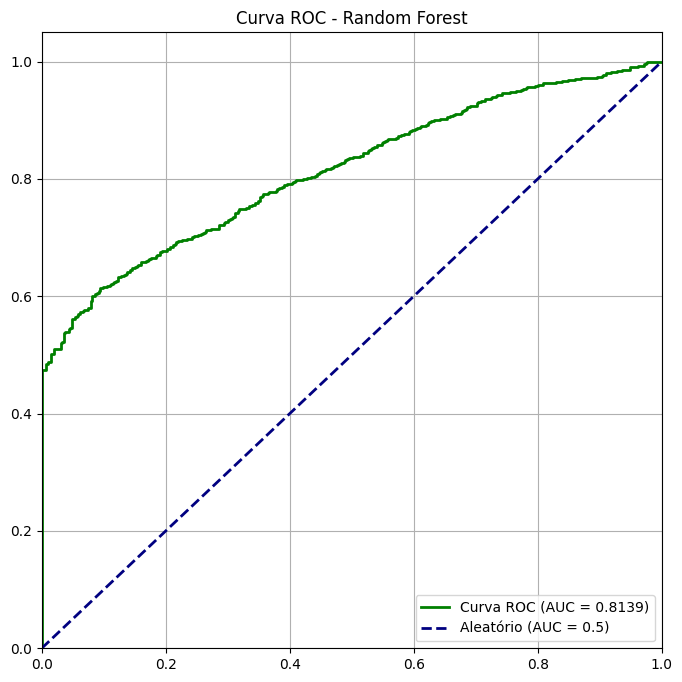

Valor final do AUC (Random Forest): 0.8139

--- 15. Plotando Importância de Features (Random Forest) ---


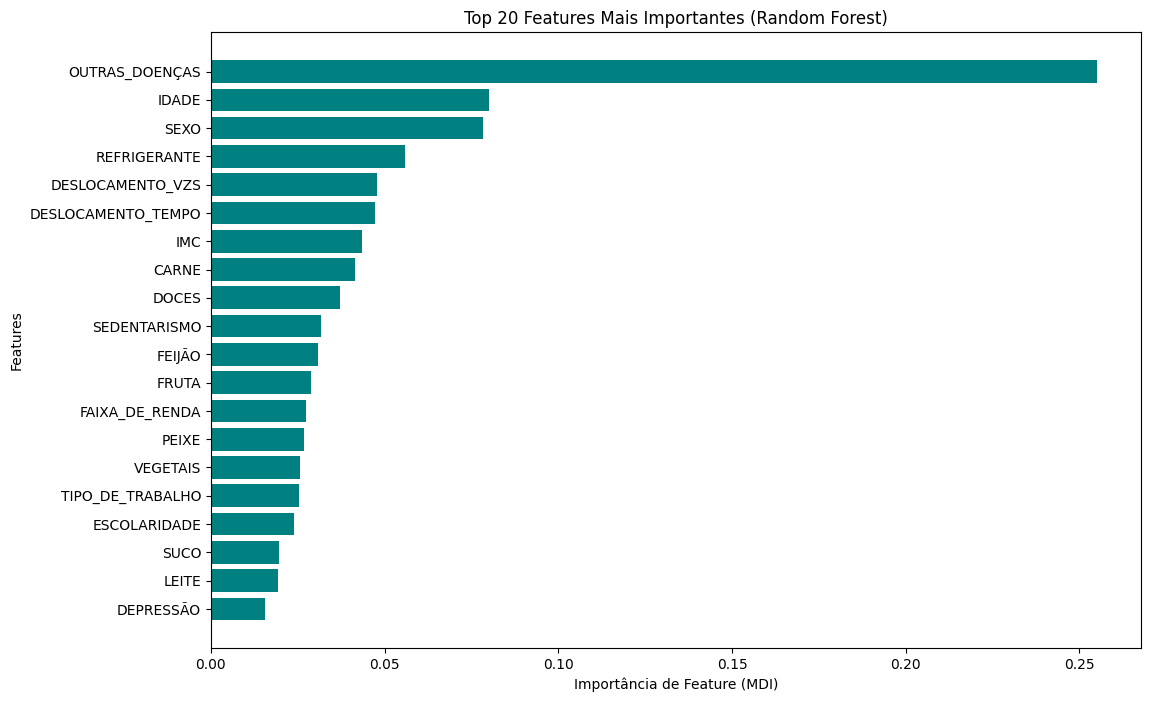


--- 16. Otimização do Threshold (Ajuste da Fronteira) ---
Melhor Threshold (Priorizando Recall da Classe 0): 0.50
Recall da Classe 0 com esse Threshold: 0.17

--- Relatório de Classificação (Threshold Ajustado) ---
              precision    recall  f1-score   support

           0       0.30      0.17      0.21       392
           1       0.93      0.96      0.95      4309

    accuracy                           0.90      4701
   macro avg       0.61      0.57      0.58      4701
weighted avg       0.87      0.90      0.88      4701



In [2]:
# Importações necessárias (permanecem as mesmas)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --------------------------------------------------------------------------------------
# 11. Implementação do Random Forest (RF) com BayesSearchCV (PESO DE CLASSE FIXO)
# --------------------------------------------------------------------------------------

print("\n" + "=" * 50)
print("--- 11. Random Forest (RF) Otimizado com class_weight='balanced' ---")
print("=" * 50)

# 11.1. Definir o Espaço de Busca (Mantemos os ajustes de velocidade)
search_spaces_rf = {
    'n_estimators': [20, 30, 40, 60, 70, 90, 120, 150],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'bootstrap': Categorical([True, False]),
}

# 11.2. Definir a Métrica de Otimização (F1-Score para equilíbrio)
scorer_rf = make_scorer(f1_score, pos_label=1)

# 11.3. Configurar e Rodar o BayesSearchCV (Otimizado)
rf_bayes_search = BayesSearchCV(
    # 🌟 AJUSTE CRUCIAL: class_weight='balanced' Fixo no Estimador
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    search_spaces=search_spaces_rf,
    
    n_iter=30, 
    scoring=scorer_rf,
    
    cv=5, 
    n_jobs=5, 
    random_state=42,
    verbose=1 
)

# Treinamento na base HÍBRIDA (balanceada e padronizada)
rf_bayes_search.fit(X_resampled, y_resampled) 
# ... (O restante do código de fit, avaliação e plotagem permanece o mesmo)
# ...

# 11.4. Extrair o Melhor Modelo e Parâmetros
modelo_rf_best = rf_bayes_search.best_estimator_
best_params_rf = rf_bayes_search.best_params_
best_score_rf = rf_bayes_search.best_score_

print(f"\n✅ Melhores Parâmetros RF (F1-Score) Encontrados: {best_params_rf}")
# Note que o best_params_ NÃO incluirá class_weight, pois ele está fixo no estimador
print(f"✅ Melhor F1-Score (Validação Cruzada): {best_score_rf:.4f}")
print("-" * 50)

# 12. Avaliação do Random Forest no Conjunto de Teste

# Avalia usando o conjunto de TESTE (X_teste_df) PADRONIZADO
y_pred_rf = modelo_rf_best.predict(X_teste_df)
y_pred_proba_rf = modelo_rf_best.predict_proba(X_teste_df)[:, 1] 

print("Relatório de Classificação RF no Conjunto de Teste (Desbalanceado):")
print(classification_report(y_teste, y_pred_rf))
print("-" * 50)


# 13. Gráfico Adicional 1: Matriz de Confusão do Random Forest (Requisitado)
print("--- 13. Plotando Matriz de Confusão (Random Forest) ---")

cm_rf = confusion_matrix(y_teste, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=modelo_rf_best.classes_)

plt.figure(figsize=(8, 6))
disp_rf.plot(cmap=plt.cm.Greens, values_format='d')
plt.title("Matriz de Confusão (Teste) - Random Forest Otimizado")
plt.show()


# 14. Gráfico Adicional 2: Curva ROC do Random Forest (Requisitado)
print("\n--- 14. Plotando Curva ROC (Random Forest) ---")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_teste, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_teste, y_pred_proba_rf)

plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Curva ROC (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Valor final do AUC (Random Forest): {roc_auc_rf:.4f}")


# 15. Gráfico Adicional 3: Importância de Features (NOVO GRÁFICO!)
print("\n--- 15. Plotando Importância de Features (Random Forest) ---")

# 15.1. Extrair as importâncias e os nomes das features
importances = modelo_rf_best.feature_importances_
feature_names = X_resampled.columns # Nomes das colunas padronizadas

# Cria um DataFrame para fácil visualização e ordenação
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20) # Mostra as 20 mais importantes

# 15.2. Plotagem
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='teal')
plt.xlabel("Importância de Feature (MDI)")
plt.ylabel("Features")
plt.title("Top 20 Features Mais Importantes (Random Forest)")
plt.gca().invert_yaxis() # Inverte o eixo Y para a maior feature ficar no topo
plt.show()

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np

# ----------------------------------------------------------------------
# 16. Otimização do Threshold (Fronteira de Decisão)
# ----------------------------------------------------------------------
print("\n" + "=" * 50)
print("--- 16. Otimização do Threshold (Ajuste da Fronteira) ---")
print("=" * 50)

y_proba = y_pred_proba_rf # Probabilidades do seu modelo RF

best_threshold = 0.5
best_f1_score = 0
best_recall_0 = 0

# Testar thresholds de 0.01 até 0.5 com passos de 0.01 (Foco na classe 0)
thresholds = np.arange(0.01, 0.51, 0.01) 

for t in thresholds:
    # Previsão binária usando o novo threshold
    y_pred_t = (y_proba > t).astype(int)
    
    # Calcular o F1-Score da Classe 0 (ou Recall da Classe 0, dependendo do seu objetivo)
    # Vamos focar no Recall da Classe 0 para garantir que ela suba, mas registrando o F1-Score geral
    f1_t = f1_score(y_teste, y_pred_t, pos_label=1) # F1 da classe 1 (a maioria)
    recall_0_t = confusion_matrix(y_teste, y_pred_t)[0, 0] / confusion_matrix(y_teste, y_pred_t)[0].sum()
    
    # Objetivo: Maximizamos o Recall da Classe 0 E o F1-score da Classe 1
    # Vamos priorizar que o Recall da Classe 0 (a classe problemática) atinja um mínimo razoável (e.g., 0.5)
    
    if recall_0_t > best_recall_0:
        best_recall_0 = recall_0_t
        best_threshold = t
        best_f1_score = f1_t # Registra o F1 que vem com este Recall 0

print(f"Melhor Threshold (Priorizando Recall da Classe 0): {best_threshold:.2f}")
print(f"Recall da Classe 0 com esse Threshold: {best_recall_0:.2f}")

# Re-avaliar o modelo usando o Threshold Otimizado
y_pred_final = (y_proba > best_threshold).astype(int)

print("\n--- Relatório de Classificação (Threshold Ajustado) ---")
print(classification_report(y_teste, y_pred_final))


--- 17. Árvore de Decisão (DT) com BayesSearchCV e F1-Score ---
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totallin

<Figure size 800x600 with 0 Axes>

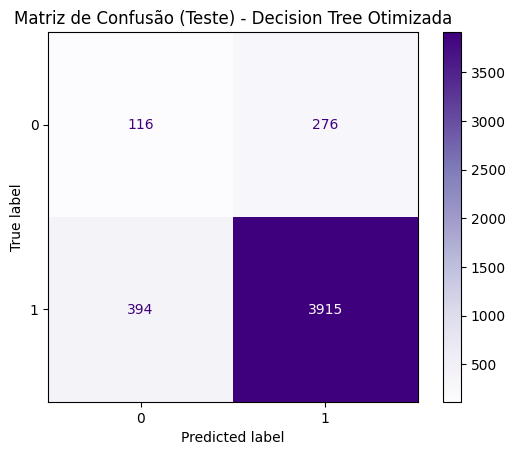


--- 20. Plotando Curva ROC (Decision Tree) ---


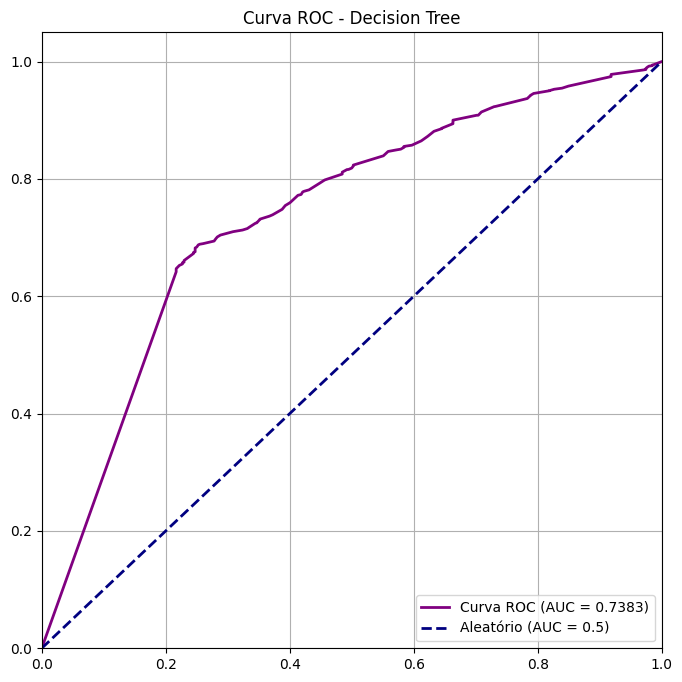


--- 21. Plotando Importância de Features (Decision Tree) ---


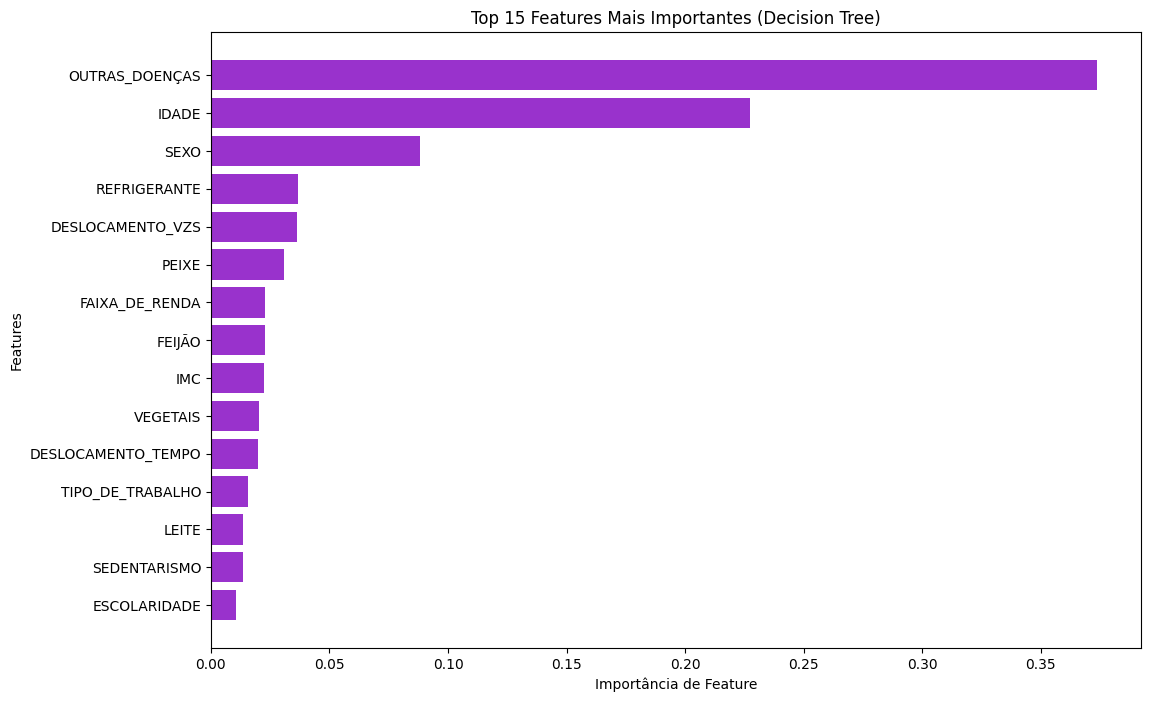

In [3]:
# Importações necessárias para o novo bloco
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --------------------------------------------------------------------------------------
# 17. Implementação da Árvore de Decisão (Decision Tree - DT) com BayesSearchCV
# --------------------------------------------------------------------------------------

print("\n" + "=" * 50)
print("--- 17. Árvore de Decisão (DT) com BayesSearchCV e F1-Score ---")
print("=" * 50)

# 17.1. Definir o Espaço de Busca (Search Space) usando dimensões do skopt
search_spaces_dt = {
    # max_depth: Profundidade máxima, crucial para controlar o overfitting
    'max_depth': [3, 5, 10, 15],
    # min_samples_split: Mínimo de amostras para dividir um nó
    'min_samples_split': [2, 5, 10, 20],
    # min_samples_leaf: Mínimo de amostras em um nó folha
    'min_samples_leaf': [1, 2, 5, 10],
        
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    # criterion: Métrica de qualidade da divisão
    'criterion': Categorical(['gini', 'entropy'])
    # class_weight: A chave para lidar com o desbalanceamento
}

# 17.2. Definir a Métrica de Otimização (F1-Score para equilíbrio)
scorer_dt = make_scorer(f1_score, pos_label=1)

# 17.3. Configurar e Rodar o BayesSearchCV
dt_bayes_search = BayesSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    search_spaces=search_spaces_dt,
    n_iter=50, # 40 iterações (rápido para DT)
    scoring=scorer_dt,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Treinamento na base HÍBRIDA (balanceada e padronizada)
dt_bayes_search.fit(X_resampled, y_resampled) 

# 17.4. Extrair o Melhor Modelo e Parâmetros
modelo_dt_best = dt_bayes_search.best_estimator_
best_params_dt = dt_bayes_search.best_params_
best_score_dt = dt_bayes_search.best_score_

print(f"\n✅ Melhores Parâmetros DT (F1-Score) Encontrados: {best_params_dt}")
print(f"✅ Melhor F1-Score (Validação Cruzada DT): {best_score_dt:.4f}")
print("-" * 50)


# 18. Avaliação do Decision Tree no Conjunto de Teste

# Avalia usando o conjunto de TESTE (X_teste_df) PADRONIZADO
y_pred_dt = modelo_dt_best.predict(X_teste_df)
y_pred_proba_dt = modelo_dt_best.predict_proba(X_teste_df)[:, 1] 

print("Relatório de Classificação DT no Conjunto de Teste (Desbalanceado):")
print(classification_report(y_teste, y_pred_dt))
print("-" * 50)


# 19. Plotagem da Matriz de Confusão do Decision Tree
print("--- 19. Plotando Matriz de Confusão (Decision Tree) ---")

cm_dt = confusion_matrix(y_teste, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=modelo_dt_best.classes_)

plt.figure(figsize=(8, 6))
disp_dt.plot(cmap=plt.cm.Purples, values_format='d')
plt.title("Matriz de Confusão (Teste) - Decision Tree Otimizada")
plt.show()


# 20. Plotagem da Curva ROC do Decision Tree
print("\n--- 20. Plotando Curva ROC (Decision Tree) ---")

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_teste, y_pred_proba_dt)
roc_auc_dt = roc_auc_score(y_teste, y_pred_proba_dt)

plt.figure(figsize=(8, 8))
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label=f'Curva ROC (AUC = {roc_auc_dt:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Curva ROC - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# 21. Gráfico Adicional: Visualização da Árvore (Visualização de Alto Valor)
print("\n--- 21. Plotando Importância de Features (Decision Tree) ---")

# Árvore de Decisão tem Feature Importance, assim como o RF
importances = modelo_dt_best.feature_importances_
feature_names = X_resampled.columns

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15) 

plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='darkorchid')
plt.xlabel("Importância de Feature")
plt.ylabel("Features")
plt.title("Top 15 Features Mais Importantes (Decision Tree)")
plt.gca().invert_yaxis()
plt.show()


--- 22. K-Nearest Neighbors (KNN) com BayesSearchCV e F1-Score ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, h

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(23), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 7, np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(7), np.int64(1), np.str_('distance')] before, using random point ['minkowski', 15, np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(7), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 29, np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(7), np.int64(1), np.str_('distance')] before, using random point ['minkowski', 29, np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(7), np.int64(1), np.str_('distance')] before, using random point ['minkowski', 29, np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(7), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 27, np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(23), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 5, np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(23), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 17, np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(23), np.int64(1), np.str_('distance')] before, using random point ['minkowski', 7, np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 5, np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['euclidean', 7, np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['minkowski', 13, np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 7, np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['euclidean', 15, np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['minkowski', 9, np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(2), np.str_('distance')] before, using random point ['manhattan', 21, np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['manhattan', 19, np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['euclidean', 13, np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(5), np.int64(1), np.str_('distance')] before, using random point ['euclidean', 23, np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ Melhores Parâmetros KNN (F1-Score) Encontrados: OrderedDict({'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'})
✅ Melhor F1-Score (Validação Cruzada KNN): 0.8426
--------------------------------------------------
Relatório de Classificação KNN no Conjunto de Teste (Desbalanceado):
              precision    recall  f1-score   support

           0       0.17      0.36      0.23       392
           1       0.94      0.84      0.88      4309

    accuracy                           0.80      4701
   macro avg       0.55      0.60      0.56      4701
weighted avg       0.87      0.80      0.83      4701

--------------------------------------------------
--- 24. Plotando Matriz de Confusão (KNN) ---


<Figure size 800x600 with 0 Axes>

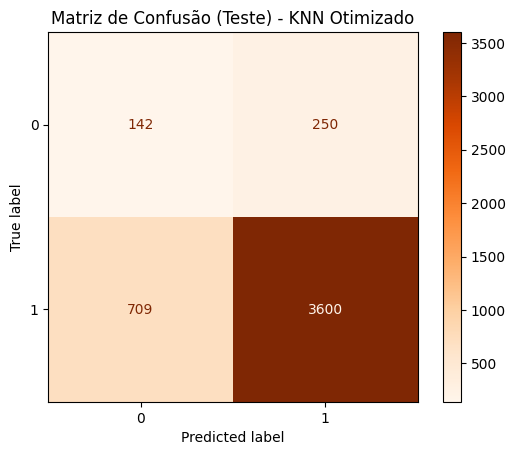


--- 25. Plotando Curva ROC (KNN) ---


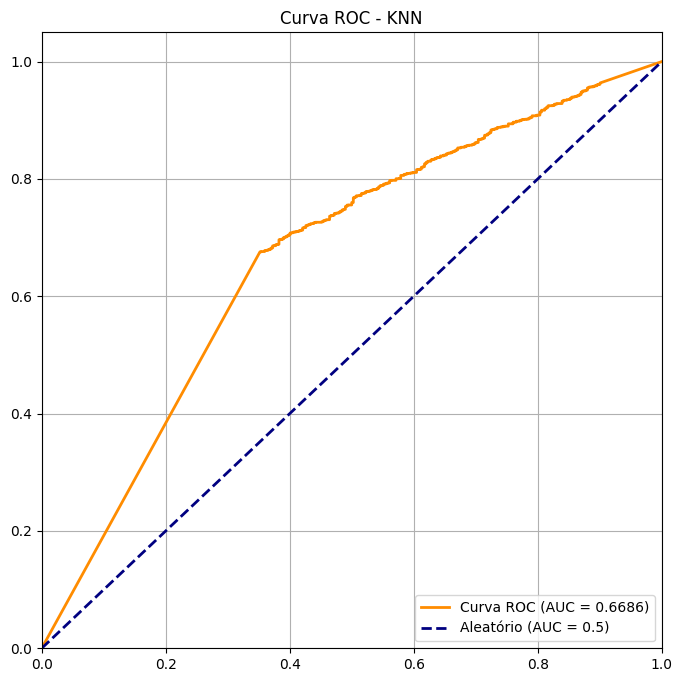

Valor final do AUC (KNN): 0.6686


In [4]:
# Importações necessárias para o KNN
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import fbeta_score, make_scorer
# --------------------------------------------------------------------------------------
# 22. Implementação do K-Nearest Neighbors (KNN) com BayesSearchCV
# --------------------------------------------------------------------------------------

print("\n" + "=" * 50)
print("--- 22. K-Nearest Neighbors (KNN) com BayesSearchCV e F1-Score ---")
print("=" * 50)

# 22.1. Definir o Espaço de Busca (Search Space) usando dimensões do skopt
search_spaces_knn = {
    # n_neighbors: O número de vizinhos (K)
    'n_neighbors': (3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29), # Intervalo razoável para K
    # weights: Como os vizinhos votam
    'weights': Categorical(['uniform', 'distance']), 
    # metric: A métrica de distância
    'metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
    'p': [1, 2]
}

# 22.2. Definir a Métrica de Otimização (F1-Score)
scorer_knn = make_scorer(fbeta_score, beta=2, pos_label=1)

# 22.3. Configurar e Rodar o BayesSearchCV
knn_bayes_search = BayesSearchCV(
    estimator=KNeighborsClassifier(),
    search_spaces=search_spaces_knn,
    n_iter=30, # Número de iterações para a busca
    scoring=scorer_knn,
    cv=5, # Cross-Validation com 5 folds
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Treinamento na base HÍBRIDA (X_resampled, y_resampled)
# X_resampled (Treino) está balanceada e padronizada (StandardScaler)
knn_bayes_search.fit(X_resampled, y_resampled) 

# 22.4. Extrair o Melhor Modelo e Parâmetros
modelo_knn_best = knn_bayes_search.best_estimator_
best_params_knn = knn_bayes_search.best_params_
best_score_knn = knn_bayes_search.best_score_

print(f"\n✅ Melhores Parâmetros KNN (F1-Score) Encontrados: {best_params_knn}")
print(f"✅ Melhor F1-Score (Validação Cruzada KNN): {best_score_knn:.4f}")
print("-" * 50)

# 23. Avaliação do KNN no Conjunto de Teste

# Avalia usando o conjunto de TESTE (X_teste_df) PADRONIZADO
y_pred_knn = modelo_knn_best.predict(X_teste_df)
y_pred_proba_knn = modelo_knn_best.predict_proba(X_teste_df)[:, 1] 

print("Relatório de Classificação KNN no Conjunto de Teste (Desbalanceado):")
print(classification_report(y_teste, y_pred_knn))
print("-" * 50)


# 24. Plotagem da Matriz de Confusão do KNN
print("--- 24. Plotando Matriz de Confusão (KNN) ---")

cm_knn = confusion_matrix(y_teste, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=modelo_knn_best.classes_)

plt.figure(figsize=(8, 6))
disp_knn.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title("Matriz de Confusão (Teste) - KNN Otimizado")
plt.show()


# 25. Plotagem da Curva ROC do KNN
print("\n--- 25. Plotando Curva ROC (KNN) ---")

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_teste, y_pred_proba_knn)
roc_auc_knn = roc_auc_score(y_teste, y_pred_proba_knn)

plt.figure(figsize=(8, 8))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Curva ROC - KNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"Valor final do AUC (KNN): {roc_auc_knn:.4f}")

--- 1. Carregando a Base de Dados: BaseFinal(v1).csv ---
--------------------------------------------------
--- 0. Visualização (t-SNE) no Conjunto de TREINO Original ---


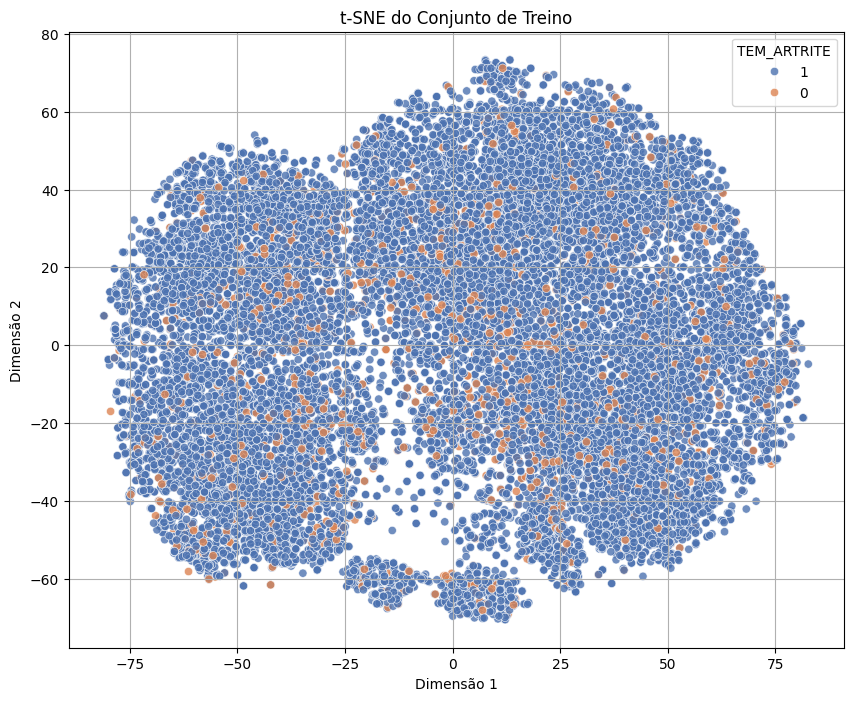

t-SNE concluído. Verifique o gráfico para ver a separação das classes.
--------------------------------------------------


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.manifold import TSNE 
# ... (outras importações)

# ... (Seu código de setup e variáveis de configuração) ...

try:
    # 1. Carregamento, 2. Definição de Features/Target e 3. Divisão em Treino/Teste
    print(f"--- 1. Carregando a Base de Dados: {NOME_ARQUIVO_ENTRADA} ---")
    base = pd.read_csv(NOME_ARQUIVO_ENTRADA) 
    X_prev = base.drop(columns=[NOME_COLUNA_TARGET])
    y_classe = base[NOME_COLUNA_TARGET]
    
    # Faz a divisão para ter o X_treino e y_treino ANTES de tudo
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X_prev, y_classe, test_size=0.20, random_state=42, stratify=y_classe 
    )
    # Resetando índice do Y de treino para plotagem
    y_treino_tsne = y_treino.reset_index(drop=True) 
    print("-" * 50)
    
    # ----------------------------------------------------------------------------------
    # 🆕 ETAPA 0: Visualização com t-SNE no Conjunto de TREINO Original 
    # ----------------------------------------------------------------------------------
    print("--- 0. Visualização (t-SNE) no Conjunto de TREINO Original ---")
    
    # --- Bloco de Inicialização TSNE (Compatibilidade de Versão) ---
    try:
        # Tentativa 1: Convenção moderna (pode ser o seu caso)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, learning_rate='auto')
    except TypeError:
        # Tentativa 2: Convenção mais antiga (se 'learning_rate' ou 'max_iter' falhar)
        print("Aviso: Tentando inicialização TSNE com convenção de parâmetros mais antiga.")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000) 
    except Exception:
        # Tentativa 3: Inicialização minimalista (para versões muito antigas)
        print("Aviso: Revertendo para inicialização TSNE minimalista.")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    # ---------------------------------------------------------------
        
    # 🎯 AQUI ESTÁ A MUDANÇA: Usa X_treino
    X_treino_tsne = tsne.fit_transform(X_treino)
    
    # Cria um DataFrame para plotar
    tsne_df = pd.DataFrame(data = X_treino_tsne, columns = ['Dimensão 1', 'Dimensão 2'])
    # 🎯 AQUI ESTÁ A MUDANÇA: Usa y_treino_tsne
    tsne_df['TEM_ARTRITE'] = y_treino_tsne.astype(str)
    
    # Plotagem
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="Dimensão 1", y="Dimensão 2",
        hue="TEM_ARTRITE",
        palette=sns.color_palette("deep", 2), 
        data=tsne_df,
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE do Conjunto de Treino')
    plt.grid(True)
    plt.show()

    print("t-SNE concluído. Verifique o gráfico para ver a separação das classes.")
    print("-" * 50)
    
    # Continua com a Etapa 4 (Padronização)
    # ... (Seu código da Etapa 4 em diante - Sem alterações) ...
  
except FileNotFoundError:
    print(f"❌ ERRO: O arquivo '{NOME_ARQUIVO_ENTRADA}' não foi encontrado.")
except ImportError as e:
    if 'skopt' in str(e):
          print("❌ ERRO: A biblioteca 'scikit-optimize (skopt)' não está instalada. Execute: pip install scikit-optimize")
    elif 'seaborn' in str(e):
          print("❌ ERRO: A biblioteca 'seaborn' não está instalada. Execute: pip install seaborn")
    else:
          print(f"❌ ERRO: Verifique se todas as bibliotecas estão instaladas. Erro: {e}")
except Exception as e:
    print(f"❌ Ocorreu um erro durante o processamento: {e}")